In [6]:
import xlrd,xlsxwriter
workbook = xlrd.open_workbook('input/Privatized data for Participants - Sandesh Brand 3.xlsx')
worksheet = workbook.sheet_by_index(0)
##########
products=[]
products.append("Tortoise")
products.append("Falcon")
variables=[]
variables.append("Gross Adds".lower())
variables.append("Leavers".lower())
variables.append("Churn".lower())
variables.append("Net Migrations".lower())
variables.append("Closing Base".lower())
variables.append("Average revenue per existing customer".lower())
variables.append("Revenue".lower())
brand="Sandesh Brand 3"
##########

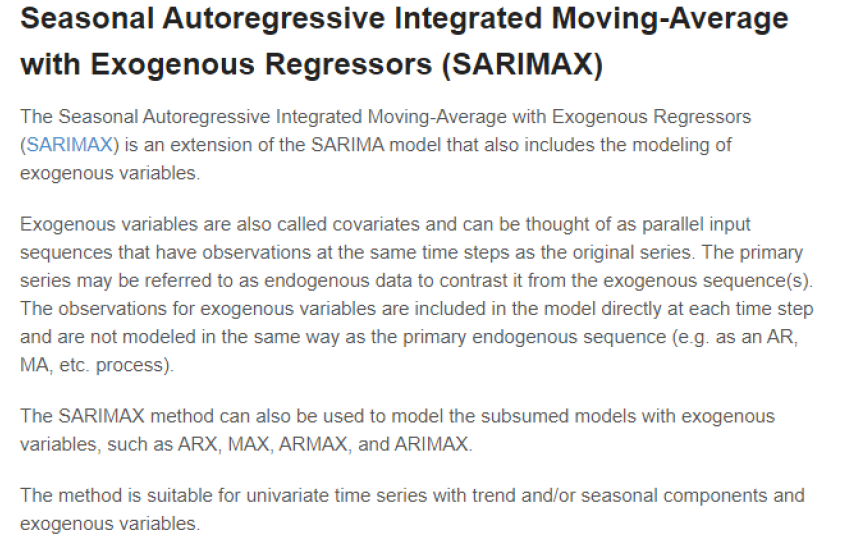

In [7]:
#find related rows
indexes=[]#
ccc=0
for i in range(1,worksheet.nrows):
    brand_name=str(worksheet.cell(i,1).value)#column with index 1 is "Generic Brand" 
    product=str(worksheet.cell(i,3).value)#column with index 3 is "Generic Product"
    variable=str(worksheet.cell(i,5).value).lower()#column with index 5 is "Generic Variable"
    #if it is sandesh brand 3 and product is falcon or tortoise and all variables!
    if brand_name==brand and (product in products):
        ok=0
        if (variables[1] in variable) or (variables[2] in variable):
            ok=1
        elif (variables[5] in variable):
            ok=1
        elif (variables[6] in variable):
            ok=1
        elif (variables[4] in variable):
            ok=1
        elif (variables[0] in variable):
            ok=1
        elif (variables[3] in variable):
            ok=1
        if ok==1:
            indexes.append(i)
print(indexes)

[39, 40, 41, 42, 44, 47, 48, 49, 50, 51, 53, 55]


<h4>Find proper parameters for sarimax model.</h4>
<li>Here we find parameter with best score for our sarimax model</li>

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm
import math
def convert_to_date(inp):
    mappe={
        'Apr':'01',
        'May':'02',
        'Jun':'03',
        'Jul':'04',
        'Aug':'05',
        'Sep':'06',
        'Oct':'07',
        'Nov':'08',
        'Dec':'09',
        'Jan':'10',
        'Feb':'11',
        'Mar':'12'
    }
    sz=len(inp)
    year='20'+inp[0]+inp[1]
    day='01'
    month=inp[sz-3]+inp[sz-2]+inp[sz-1]
    datee=year+'-'+mappe[month]+'-'+day
    return datee
def find_best_parameters(dx,siz,p,d,q,trendd,pr,fix,flag):#find performance of model with parameters p,d,q
    i=0
    train=[]
    test=[]
    testt=[]
    fest=[]
    tr_start,tr_end = '!','!'
    te_start,te_end = '!','!'
    while i<worksheet.ncols:
        ab=str(type(worksheet.cell(dx,i).value))=="<class 'float'>"
        if ab==True and len(str(worksheet.cell(dx,i).value))>0 and i<siz:
            date=str(worksheet.cell(0,i).value)
            date=convert_to_date(date)
            val=worksheet.cell(dx,i).value
            rw=[]
            rw.append(date)
            rw.append(val)
            train.append(rw)
            if tr_start=='!':
                tr_start=date
            tr_end=date
        elif ab==True and len(str(worksheet.cell(dx,i).value))>0 :
            date=str(worksheet.cell(0,i).value)
            date=convert_to_date(date)
            rw=[]
            rw.append(date)
            test.append(rw)
            testt.append(worksheet.cell(dx,i).value)
            fest.append(date)
            if te_start=='!':
                te_start=date
            te_end=date
        i+=1
    if flag==1:#replace anomalies value with fixing
        for i in range(0,len(train)):
            if str(train[i][0]) in fix:
                train[i][1]=fix[str(train[i][0])]
        for i in range(0,len(fest)):
            if str(fest[i]) in fix:
                testt[i]=fix[str(fest[i])]
    train=pd.DataFrame(train)
    train.columns=['date','value']
    train['date']=pd.to_datetime(train['date'])
    train=train.set_index('date')
    test=pd.DataFrame(test)
    test.columns=['date']
    test['date']=pd.to_datetime(test['date'])
    test=test.set_index('date')
    df=pd.concat([train,test],sort=True)
    buf=df.copy()
    ##### make feature!
    buf['quarter']=buf.index.quarter
    quarter_dummies=pd.get_dummies(buf['quarter'])
    quarter_dummies.columns = ['quarter-' + str(m) for m in range(min(buf.index.quarter),max(buf.index.quarter)+1)]
    buf = pd.concat([buf,quarter_dummies],axis=1,join_axes=[buf.index]).drop(['quarter'],axis=1)
    ##### make feature!
    buf['month']=buf.index.month
    month_dummies=pd.get_dummies(buf['month'])
    month_dummies.columns = ['month-' + str(m) for m in range(min(buf.index.month),max(buf.index.month)+1)]
    buf = pd.concat([buf,month_dummies],axis=1,join_axes=[buf.index]).drop(['month'],axis=1)
    
    ####
    tra = buf['value'][tr_start:tr_end].dropna()
    tes = buf['value'][te_start:te_end].dropna()
    exog_train=buf.drop(['value'],axis=1)[tr_start:tr_end].dropna()
    exog_test=buf.drop(['value'],axis=1)[te_start:te_end].dropna()
    #sarimax MODEL
    ret=0
    try:
        sarimax = sm.tsa.statespace.SARIMAX(tra,order=(p,d,q),seasonal_order=(p,d,q,12),exog=exog_train,enforce_stationarity=False,enforce_invertibility=False,trend=trendd).fit()
    except:
        ret=1
    if ret==1:
        return 1000000001.0,[1,1,0,0]
    pred = sarimax.predict(tr_end,te_end,exog=exog_test)[1:]#doing prediction
    avg_mape=0.0
    num=0.0
    cant=0
    mapes=[]
    for vl in pred:#find MAPE
        p2=testt[cant]
        cant+=1
        mpp=p2-vl
        mpp/=p2
        if mpp<0.0:
            mpp=mpp*-1.0
        mpp*=100.0
        mapes.append(mpp)
        avg_mape+=mpp
        num+=1.0
    #average mape
    if num>0:
        avg_mape=avg_mape/num
    #find MSE
    summ=0.0
    for vl in mapes:
        summ=summ+(vl-avg_mape)*(vl-avg_mape)
    summ=summ/num
    if summ<1.0:
        summ=1.0
    summ=math.sqrt(math.sqrt(summ))
    if pr==1:
        print("size "+str(len(testt))+" and average MAPE: "+str(avg_mape)+" and MSE: "+str(summ)+" and final weight: "+str(summ*avg_mape)+" for parameters p,d,q and trend of sarimax ",p,d,q,trendd)
    return summ*avg_mape,trendd
def best_parameters(dxx,siz,pr,fix={},flag=0):#find best parameters for sarimax model
    print("choosing parameters for sarimax model")
    best=1000000000.0
    pp,dd,qq=0,0,0
    ftrend=[1,1,0,0]
    for t1 in range(0,2):
        for t2 in range(0,2):
            for t3 in range(0,2):
                for t4 in range(0,2):
                    for p in range(0,4):
                        for d in range(0,2):
                            for q in range(0,2):
                                res,trn=find_best_parameters(dxx,siz,p,d,q,[t1,t2,t3,t4],pr,fix,flag)
                                if res<best:
                                    pp=p
                                    dd=d
                                    qq=q
                                    ftrend=trn
                                    best=res
    print("Final parameters p,d,q and trend of sarimax are ",pp,dd,qq,ftrend)
    return pp,dd,qq,ftrend

<h4>Smoothing function</h4>
<li>Here we find anomalies value in data for last 7 months of training data. you can change this for bigger training data</li>
<li>It work very good in finding anomalies of training data.</li>

In [9]:
fix_anomalies={}#store cells with new value that we should fix anomalies of them!
anomalies_indexs={}#for saving in worksheet in submission!
def smoothing(dx,siz,p,d,q,trendd):#smoothing data! ^_^
    i=0
    train=[]
    test=[]
    testt=[]
    tr_start,tr_end = '!','!'
    te_start,te_end = '!','!'
    while i<worksheet.ncols:
        ab=str(type(worksheet.cell(dx,i).value))=="<class 'float'>"
        if ab==True and len(str(worksheet.cell(dx,i).value))>0 and i<siz:
            date=str(worksheet.cell(0,i).value)
            date=convert_to_date(date)
            val=worksheet.cell(dx,i).value
            rw=[]
            rw.append(date)
            rw.append(val)
            train.append(rw)
            if tr_start=='!':
                tr_start=date
            tr_end=date
        elif ab==True and len(str(worksheet.cell(dx,i).value))>0 :
            date=str(worksheet.cell(0,i).value)
            date=convert_to_date(date)
            rw=[]
            rw.append(date)
            test.append(rw)
            rww=[]
            rww.append(date)
            rww.append(worksheet.cell(dx,i).value)
            testt.append(rww)
            if te_start=='!':
                te_start=date
            te_end=date
        i+=1
    train=pd.DataFrame(train)
    train.columns=['date','value']
    train['date']=pd.to_datetime(train['date'])
    train=train.set_index('date')
    test=pd.DataFrame(test)
    test.columns=['date']
    test['date']=pd.to_datetime(test['date'])
    test=test.set_index('date')
    df=pd.concat([train,test],sort=True)
    buf=df.copy()
    ##### make feature!
    buf['quarter']=buf.index.quarter
    quarter_dummies=pd.get_dummies(buf['quarter'])
    quarter_dummies.columns = ['quarter-' + str(m) for m in range(min(buf.index.quarter),max(buf.index.quarter)+1)]
    buf = pd.concat([buf,quarter_dummies],axis=1,join_axes=[buf.index]).drop(['quarter'],axis=1)
    ##### make feature!
    buf['month']=buf.index.month
    month_dummies=pd.get_dummies(buf['month'])
    month_dummies.columns = ['month-' + str(m) for m in range(min(buf.index.month),max(buf.index.month)+1)]
    buf = pd.concat([buf,month_dummies],axis=1,join_axes=[buf.index]).drop(['month'],axis=1)
    
    ####
    tra = buf['value'][tr_start:tr_end].dropna()
    tes = buf['value'][te_start:te_end].dropna()
    exog_train=buf.drop(['value'],axis=1)[tr_start:tr_end].dropna()
    exog_test=buf.drop(['value'],axis=1)[te_start:te_end].dropna()
    #sarimax MODEL
    ret=0
    try:
        sarimax = sm.tsa.statespace.SARIMAX(tra,order=(p,d,q),seasonal_order=(p,d,q,12),exog=exog_train,enforce_stationarity=False,enforce_invertibility=False,trend=trendd).fit()
    except:
        ret=1
    if ret==1:
        return
    predd = sarimax.predict(tr_end,te_end,exog=exog_test)[1:]
    avg_pre=0.0
    numm=0.0
    for j in range(0,len(predd)):#find average difference between real values and predictions
        pred=predd[j]
        real_value=testt[j][1]
        if pred<0.0:
            pred*=-1.0
        if real_value<0.0:
            real_value*=-1.0
        dif=(real_value-pred)*100.0
        if dif<0.0:
            dif*=-1.0
        avg_pre+=dif
        numm+=1.0
    if numm>0.0:
        avg_pre/=numm
    for j in range(0,len(predd)):#check if difference of real value and predicted value was far from average, it is anomalies!
        pred=predd[j]
        futur=pred
        real_value=testt[j][1]
        if pred<0.0:
            pred*=-1.0
        if real_value<0.0:
            real_value*=-1.0
        dif=(real_value-pred)*100.0
        if dif<0.0:
            dif*=-1.0
        #print(dif,avg_pre)
        if dif>(avg_pre*1.7):#is difference between real value and predicted value was more than 1.7 * average of difference
            print("An anomalies : new value = "+str(futur)+" previous value = "+str(testt[j][1])+" . Date "+str(testt[j][0]))
            fix_anomalies[dx][str(testt[j][0])]=futur
            anomalies_indexs[dx][j]=futur

<h4>Here we fix anomalies and smoothing some part of data!</h4>

In [10]:
for dx in indexes:
    fix_anomalies[dx]={}
    anomalies_indexs[dx]={}
    last=0
    siz=0
    i=0
    while i<worksheet.ncols:
        ab=str(type(worksheet.cell(dx,i).value))=="<class 'float'>"
        if ab==True and len(str(worksheet.cell(dx,i).value))>0:#create train data
            last=i
        i+=1
    dad=6#fix anomalies in last 7 month of data
    print("*********************** row "+str(dx)+" For product "+str(worksheet.cell(dx,3).value)+" and variable "+str(worksheet.cell(dx,5).value)+" **************************")
    p,d,q,trendd=best_parameters(dx,last-dad,1)#find parameters of sarimax model
    #begin fixing anomalies
    smoothing(dx,last-dad,p,d,q,trendd)
    #fixing anomalies end!
    

*********************** row 39 For product Tortoise and variable Average revenue per existing customer  - Tortoise **************************
choosing parameters for sarimax model
size 7 and average MAPE: 117.64565851444168 and MSE: 6.828388820264864 and final weight: 803.3302993527114 for parameters p,d,q and trend of sarimax  0 0 0 [0, 0, 0, 0]
size 7 and average MAPE: 471.8001686937345 and MSE: 23.1542217998134 and final weight: 10924.165751124106 for parameters p,d,q and trend of sarimax  0 1 0 [0, 0, 0, 0]
size 7 and average MAPE: 117.65336720572783 and MSE: 6.828058650026699 and final weight: 803.3440916538375 for parameters p,d,q and trend of sarimax  1 0 0 [0, 0, 0, 0]
size 7 and average MAPE: 713.0229579618033 and MSE: 26.18418073749556 and final weight: 18669.922001255556 for parameters p,d,q and trend of sarimax  0 0 0 [0, 0, 0, 1]
size 7 and average MAPE: 400.6090403248487 and MSE: 17.489563173226045 and final weight: 7006.477118526902 for parameters p,d,q and trend of sari

Final parameters p,d,q and trend of sarimax are  1 0 0 [0, 1, 0, 0]
An anomalies : new value = 0.050101192177016536 previous value = 3.890642339723759 . Date 2018-09-01
*********************** row 40 For product Tortoise and variable Leavers - Tortoise **************************
choosing parameters for sarimax model
size 7 and average MAPE: 190.23554300136314 and MSE: 12.204967526988925 and final weight: 2321.818624810742 for parameters p,d,q and trend of sarimax  0 0 0 [0, 0, 0, 0]
size 7 and average MAPE: 200.61278316716502 and MSE: 15.197948661209693 and final weight: 3048.902779356966 for parameters p,d,q and trend of sarimax  0 0 1 [0, 0, 0, 0]
size 7 and average MAPE: 940.4459587872183 and MSE: 30.411607579643075 and final weight: 28600.473448498065 for parameters p,d,q and trend of sarimax  0 1 0 [0, 0, 0, 0]
size 7 and average MAPE: 513.74656390602 and MSE: 21.171199763393552 and final weight: 10876.631132211382 for parameters p,d,q and trend of sarimax  0 1 1 [0, 0, 0, 0]
size

size 7 and average MAPE: 775.6721076076708 and MSE: 27.40906117679903 and final weight: 21260.44425055529 for parameters p,d,q and trend of sarimax  3 1 1 [0, 0, 1, 0]
size 7 and average MAPE: 540.1237726041943 and MSE: 24.72596516956524 and final weight: 13355.081588665484 for parameters p,d,q and trend of sarimax  0 0 0 [0, 0, 1, 1]
size 7 and average MAPE: 693.2651435776592 and MSE: 30.389292876238414 and final weight: 21067.83748906896 for parameters p,d,q and trend of sarimax  0 0 1 [0, 0, 1, 1]
size 7 and average MAPE: 2718.0376100877525 and MSE: 49.94978248891068 and final weight: 135765.38742056183 for parameters p,d,q and trend of sarimax  0 1 0 [0, 0, 1, 1]
size 7 and average MAPE: 3618.4395424643362 and MSE: 58.39465890190799 and final weight: 211297.5428393809 for parameters p,d,q and trend of sarimax  0 1 1 [0, 0, 1, 1]
size 7 and average MAPE: 543.0636169584875 and MSE: 25.431922470228923 and final weight: 13811.15180289035 for parameters p,d,q and trend of sarimax  1 0 0

size 7 and average MAPE: 266.7400311222349 and MSE: 18.6353805918971 and final weight: 4970.801999057324 for parameters p,d,q and trend of sarimax  0 0 0 [0, 1, 1, 0]
size 7 and average MAPE: 484.66074730283754 and MSE: 25.057663075138407 and final weight: 12144.465711659299 for parameters p,d,q and trend of sarimax  0 0 1 [0, 1, 1, 0]
size 7 and average MAPE: 1470.213434080845 and MSE: 37.26944388013633 and final weight: 54794.03707329856 for parameters p,d,q and trend of sarimax  0 1 0 [0, 1, 1, 0]
size 7 and average MAPE: 1284.7583095022594 and MSE: 34.638373948275934 and final weight: 44501.93875769409 for parameters p,d,q and trend of sarimax  0 1 1 [0, 1, 1, 0]
size 7 and average MAPE: 393.07415495657875 and MSE: 21.676889143898894 and final weight: 8520.624882325494 for parameters p,d,q and trend of sarimax  1 0 0 [0, 1, 1, 0]
size 7 and average MAPE: 3043.154798793355 and MSE: 50.694656502464866 and final weight: 154271.68720865672 for parameters p,d,q and trend of sarimax  1 0

size 7 and average MAPE: 435.04611236531275 and MSE: 21.901374909535615 and final weight: 9528.108009848673 for parameters p,d,q and trend of sarimax  0 0 1 [1, 0, 0, 1]
size 7 and average MAPE: 2098.422920411341 and MSE: 44.168510932724516 and final weight: 92684.21570166801 for parameters p,d,q and trend of sarimax  0 1 0 [1, 0, 0, 1]
size 7 and average MAPE: 2688.1120922542023 and MSE: 50.30650290979325 and final weight: 135229.51879083645 for parameters p,d,q and trend of sarimax  0 1 1 [1, 0, 0, 1]
size 7 and average MAPE: 257.1360378298436 and MSE: 16.111039732469592 and final weight: 4142.728922126415 for parameters p,d,q and trend of sarimax  1 0 0 [1, 0, 0, 1]
size 7 and average MAPE: 7846.756513966472 and MSE: 73.75153372914967 and final weight: 578710.3277042231 for parameters p,d,q and trend of sarimax  1 0 1 [1, 0, 0, 1]
size 7 and average MAPE: 1761.6992422454318 and MSE: 40.476033078967106 and final weight: 71306.59680431738 for parameters p,d,q and trend of sarimax  1 1

size 7 and average MAPE: 1306.648495197938 and MSE: 35.346977536431325 and final weight: 46186.07500777331 for parameters p,d,q and trend of sarimax  0 1 0 [1, 1, 0, 0]
size 7 and average MAPE: 1452.875430523633 and MSE: 36.91773706842827 and final weight: 53636.873137251016 for parameters p,d,q and trend of sarimax  0 1 1 [1, 1, 0, 0]
size 7 and average MAPE: 211.4080633906652 and MSE: 16.574909358044764 and final weight: 3504.0694882600574 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 0, 0]
size 7 and average MAPE: 242.3175821652169 and MSE: 18.70359287758072 and final weight: 4532.209403897932 for parameters p,d,q and trend of sarimax  1 0 1 [1, 1, 0, 0]
size 7 and average MAPE: 1037.131967486465 and MSE: 31.39758375791559 and final weight: 32563.437817168076 for parameters p,d,q and trend of sarimax  1 1 0 [1, 1, 0, 0]
size 7 and average MAPE: 623.8482820117308 and MSE: 22.87208745289798 and final weight: 14268.71246351247 for parameters p,d,q and trend of sarimax  1 1 1 

size 7 and average MAPE: 26773.5184197216 and MSE: 159.00470419547887 and final weight: 4257115.376600038 for parameters p,d,q and trend of sarimax  0 1 1 [1, 1, 1, 1]
size 7 and average MAPE: 530.9285766764776 and MSE: 25.23448640520646 and final weight: 13397.709950278191 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 1, 1]
size 7 and average MAPE: 481.61063620747393 and MSE: 26.132411677902397 and final weight: 12585.647413830195 for parameters p,d,q and trend of sarimax  1 0 1 [1, 1, 1, 1]
size 7 and average MAPE: 4982.139991111612 and MSE: 66.49541072295312 and final weight: 331289.4449882167 for parameters p,d,q and trend of sarimax  1 1 0 [1, 1, 1, 1]
size 7 and average MAPE: 13212.806758971654 and MSE: 110.27208287299786 and final weight: 1457003.7219102285 for parameters p,d,q and trend of sarimax  1 1 1 [1, 1, 1, 1]
size 7 and average MAPE: 484.36088397459696 and MSE: 26.26440541732952 and final weight: 12721.45062500492 for parameters p,d,q and trend of sarimax  2 0

size 7 and average MAPE: 30.12322819869902 and MSE: 2.4794549892598376 and final weight: 74.68918844987692 for parameters p,d,q and trend of sarimax  0 0 1 [0, 0, 1, 0]
size 7 and average MAPE: 9.096869981069885 and MSE: 2.2107336614566613 and final weight: 20.110756681045814 for parameters p,d,q and trend of sarimax  0 1 0 [0, 0, 1, 0]
size 7 and average MAPE: 5.765588108720081 and MSE: 1.6335326813630193 and final weight: 9.418276602872254 for parameters p,d,q and trend of sarimax  0 1 1 [0, 0, 1, 0]
size 7 and average MAPE: 5.6500301803118615 and MSE: 2.4364067907595905 and final weight: 13.765771899308453 for parameters p,d,q and trend of sarimax  1 0 0 [0, 0, 1, 0]
size 7 and average MAPE: 12.06768681860076 and MSE: 2.3927122437669297 and final weight: 28.87450200481083 for parameters p,d,q and trend of sarimax  1 0 1 [0, 0, 1, 0]
size 7 and average MAPE: 5.9168575923669255 and MSE: 1.7012286331904802 and final weight: 10.0659275546451 for parameters p,d,q and trend of sarimax  1 

size 7 and average MAPE: 34.063852269194264 and MSE: 4.170392810029015 and final weight: 142.0596445853383 for parameters p,d,q and trend of sarimax  0 1 0 [0, 1, 0, 1]
size 7 and average MAPE: 125.73008579162912 and MSE: 7.544295358161245 and final weight: 948.5449026190026 for parameters p,d,q and trend of sarimax  0 1 1 [0, 1, 0, 1]
size 7 and average MAPE: 14.631325878306106 and MSE: 2.6068540634147914 and final weight: 38.141731319008265 for parameters p,d,q and trend of sarimax  1 0 0 [0, 1, 0, 1]
size 7 and average MAPE: 5.771720851240891 and MSE: 2.4346076601008266 and final weight: 14.051875796394738 for parameters p,d,q and trend of sarimax  1 0 1 [0, 1, 0, 1]
size 7 and average MAPE: 26.40687721197083 and MSE: 3.328982882552136 and final weight: 87.90804222030697 for parameters p,d,q and trend of sarimax  1 1 0 [0, 1, 0, 1]
size 7 and average MAPE: 125.53148750948651 and MSE: 7.118003330426964 and final weight: 893.5335461659758 for parameters p,d,q and trend of sarimax  1 1

size 7 and average MAPE: 4.945839106247428 and MSE: 1.9333403398699096 and final weight: 9.561990258614292 for parameters p,d,q and trend of sarimax  0 1 1 [1, 0, 0, 0]
size 7 and average MAPE: 4.575686696383916 and MSE: 1.6717142260287028 and final weight: 7.64924054419527 for parameters p,d,q and trend of sarimax  1 0 0 [1, 0, 0, 0]
size 7 and average MAPE: 7.934875559449191 and MSE: 2.2709270342625003 and final weight: 18.019523421461948 for parameters p,d,q and trend of sarimax  1 0 1 [1, 0, 0, 0]
size 7 and average MAPE: 6.081082901818251 and MSE: 2.1430633008012188 and final weight: 13.032145596016473 for parameters p,d,q and trend of sarimax  1 1 0 [1, 0, 0, 0]
size 7 and average MAPE: 8.371784639692754 and MSE: 2.2366968067296376 and final weight: 18.725143970229013 for parameters p,d,q and trend of sarimax  1 1 1 [1, 0, 0, 0]
size 7 and average MAPE: 10.705074233059369 and MSE: 1.9830092779122532 and final weight: 21.228261524896126 for parameters p,d,q and trend of sarimax  2

size 7 and average MAPE: 10.869574872393098 and MSE: 2.24594804030006 and final weight: 24.412500383546053 for parameters p,d,q and trend of sarimax  1 0 0 [1, 0, 1, 1]
size 7 and average MAPE: 7.106098679801929 and MSE: 2.4467101127357225 and final weight: 17.386563501969345 for parameters p,d,q and trend of sarimax  1 0 1 [1, 0, 1, 1]
size 7 and average MAPE: 27.03799530300373 and MSE: 3.353054503104493 and final weight: 90.65987190565478 for parameters p,d,q and trend of sarimax  1 1 0 [1, 0, 1, 1]
size 7 and average MAPE: 130.88171401026625 and MSE: 7.276813425108379 and final weight: 952.4018136111009 for parameters p,d,q and trend of sarimax  1 1 1 [1, 0, 1, 1]
size 7 and average MAPE: 41.739414575876424 and MSE: 4.099029087069207 and final weight: 171.09107442375787 for parameters p,d,q and trend of sarimax  2 0 0 [1, 0, 1, 1]
size 7 and average MAPE: 44.25544229810801 and MSE: 4.445128779514087 and final weight: 196.72114020944494 for parameters p,d,q and trend of sarimax  2 0 

size 7 and average MAPE: 8.591197715312463 and MSE: 1.9960402694004589 and final weight: 17.148376602144896 for parameters p,d,q and trend of sarimax  1 0 1 [1, 1, 1, 0]
size 7 and average MAPE: 9.09501411987648 and MSE: 2.2713347578982015 and final weight: 20.657821694050366 for parameters p,d,q and trend of sarimax  1 1 0 [1, 1, 1, 0]
size 7 and average MAPE: 65.56927173003758 and MSE: 4.784900477380872 and final weight: 313.742439602573 for parameters p,d,q and trend of sarimax  1 1 1 [1, 1, 1, 0]
size 7 and average MAPE: 18.754350747493596 and MSE: 3.0958404292659067 and final weight: 58.06047726872396 for parameters p,d,q and trend of sarimax  2 0 0 [1, 1, 1, 0]
size 7 and average MAPE: 50.41236034493648 and MSE: 4.611000773333426 and final weight: 232.45143253606548 for parameters p,d,q and trend of sarimax  2 0 1 [1, 1, 1, 0]
size 7 and average MAPE: 15.562294890205743 and MSE: 2.35167530835906 and final weight: 36.597464634699215 for parameters p,d,q and trend of sarimax  2 1 0

size 7 and average MAPE: 101.58715159307955 and MSE: 5.636866450298622 and final weight: 572.6332065964303 for parameters p,d,q and trend of sarimax  1 0 0 [0, 0, 0, 1]
size 7 and average MAPE: 685.0167285430153 and MSE: 25.670382488405536 and final weight: 17584.64143265547 for parameters p,d,q and trend of sarimax  1 0 1 [0, 0, 0, 1]
size 7 and average MAPE: 226.23507878430584 and MSE: 14.755720056879772 and final weight: 3338.261489587357 for parameters p,d,q and trend of sarimax  1 1 0 [0, 0, 0, 1]
size 7 and average MAPE: 118.50707955305354 and MSE: 8.675181881954854 and final weight: 1028.0704694220326 for parameters p,d,q and trend of sarimax  1 1 1 [0, 0, 0, 1]
size 7 and average MAPE: 298.54918147950247 and MSE: 22.61302655717139 and final weight: 6751.10056941777 for parameters p,d,q and trend of sarimax  2 0 0 [0, 0, 0, 1]
size 7 and average MAPE: 1047.5184738421958 and MSE: 36.065343943941144 and final weight: 37779.11404675111 for parameters p,d,q and trend of sarimax  2 0

size 7 and average MAPE: 119.18341654839472 and MSE: 9.272253380641633 and final weight: 1105.0988370072728 for parameters p,d,q and trend of sarimax  1 0 1 [0, 1, 0, 0]
size 7 and average MAPE: 217.20494434099479 and MSE: 17.534908742501045 and final weight: 3808.6688774393624 for parameters p,d,q and trend of sarimax  1 1 0 [0, 1, 0, 0]
size 7 and average MAPE: 263.55012165857676 and MSE: 18.150994219873432 and final weight: 4783.696734871766 for parameters p,d,q and trend of sarimax  1 1 1 [0, 1, 0, 0]
size 7 and average MAPE: 196.86129959473254 and MSE: 12.952579847284591 and final weight: 2549.861701840987 for parameters p,d,q and trend of sarimax  2 0 0 [0, 1, 0, 0]
size 7 and average MAPE: 233.5911627046739 and MSE: 13.786974608342604 and final weight: 3220.515428942565 for parameters p,d,q and trend of sarimax  2 0 1 [0, 1, 0, 0]
size 7 and average MAPE: 316.0248043882243 and MSE: 22.630232640721104 and final weight: 7151.714843543896 for parameters p,d,q and trend of sarimax  

size 7 and average MAPE: 1973.80643600416 and MSE: 44.662463829553765 and final weight: 88155.05855457623 for parameters p,d,q and trend of sarimax  1 1 0 [0, 1, 1, 1]
size 7 and average MAPE: 3646.2961098884593 and MSE: 59.39188522532738 and final weight: 216560.40005605307 for parameters p,d,q and trend of sarimax  1 1 1 [0, 1, 1, 1]
size 7 and average MAPE: 339.1834474114102 and MSE: 19.888473023935582 and final weight: 6745.840844007305 for parameters p,d,q and trend of sarimax  2 0 0 [0, 1, 1, 1]
size 7 and average MAPE: 418.23845509873263 and MSE: 26.863391784050215 and final weight: 11235.303478473148 for parameters p,d,q and trend of sarimax  2 0 1 [0, 1, 1, 1]
size 7 and average MAPE: 2225.250328003344 and MSE: 46.59436594156099 and final weight: 103684.12809456642 for parameters p,d,q and trend of sarimax  2 1 0 [0, 1, 1, 1]
size 7 and average MAPE: 1845.4964140633788 and MSE: 42.47123861514158 and final weight: 78380.51856507389 for parameters p,d,q and trend of sarimax  2 1

size 7 and average MAPE: 245.98924984802406 and MSE: 16.640520774112538 and final weight: 4093.389222304404 for parameters p,d,q and trend of sarimax  1 1 1 [1, 0, 1, 0]
size 7 and average MAPE: 196.48962329299383 and MSE: 15.386110729424644 and final weight: 3023.2111011689385 for parameters p,d,q and trend of sarimax  2 0 0 [1, 0, 1, 0]
size 7 and average MAPE: 278.4110964736158 and MSE: 21.30024611870527 and final weight: 5930.224877066615 for parameters p,d,q and trend of sarimax  2 0 1 [1, 0, 1, 0]
size 7 and average MAPE: 254.54061366061347 and MSE: 18.391480850128687 and final weight: 4681.378821719177 for parameters p,d,q and trend of sarimax  2 1 0 [1, 0, 1, 0]
size 7 and average MAPE: 300.42880938467295 and MSE: 21.348261743213193 and final weight: 6413.632857945902 for parameters p,d,q and trend of sarimax  2 1 1 [1, 0, 1, 0]
size 7 and average MAPE: 273.30209152143277 and MSE: 16.11600817015751 and final weight: 4404.538739880546 for parameters p,d,q and trend of sarimax  3

size 7 and average MAPE: 434.3647103666987 and MSE: 26.483274108403258 and final weight: 11503.399687658472 for parameters p,d,q and trend of sarimax  2 0 0 [1, 1, 0, 1]
size 7 and average MAPE: 817.5231919505928 and MSE: 33.68027849019513 and final weight: 27534.408777089215 for parameters p,d,q and trend of sarimax  2 0 1 [1, 1, 0, 1]
size 7 and average MAPE: 602.5802587729326 and MSE: 26.00584787922492 and final weight: 15670.61054467287 for parameters p,d,q and trend of sarimax  2 1 0 [1, 1, 0, 1]
size 7 and average MAPE: 212.0576915100648 and MSE: 15.349067486408389 and final weight: 3254.887817999956 for parameters p,d,q and trend of sarimax  2 1 1 [1, 1, 0, 1]
size 7 and average MAPE: 357.51282308907 and MSE: 20.656737986740985 and final weight: 7385.048713451002 for parameters p,d,q and trend of sarimax  3 0 0 [1, 1, 0, 1]
size 7 and average MAPE: 314.2666421233005 and MSE: 20.23656619830576 and final weight: 6359.677707247436 for parameters p,d,q and trend of sarimax  3 0 1 [1

size 7 and average MAPE: 145.78844736800156 and MSE: 11.653524492565909 and final weight: 1698.949242136162 for parameters p,d,q and trend of sarimax  2 0 0 [0, 0, 0, 0]
size 7 and average MAPE: 139.3759969534545 and MSE: 13.537658863195395 and final weight: 1886.8247004736274 for parameters p,d,q and trend of sarimax  2 0 1 [0, 0, 0, 0]
size 7 and average MAPE: 133.29457726896268 and MSE: 13.849611167271833 and final weight: 1846.0780658810038 for parameters p,d,q and trend of sarimax  2 1 0 [0, 0, 0, 0]
size 7 and average MAPE: 137.18602269761067 and MSE: 14.396049941221275 and final weight: 1974.9368339923185 for parameters p,d,q and trend of sarimax  2 1 1 [0, 0, 0, 0]
size 7 and average MAPE: 175.9510567746093 and MSE: 15.90386753058705 and final weight: 2798.3022988101875 for parameters p,d,q and trend of sarimax  3 0 0 [0, 0, 0, 0]
size 7 and average MAPE: 174.01848217802467 and MSE: 15.965917897473007 and final weight: 2778.3647990972117 for parameters p,d,q and trend of sarima

size 7 and average MAPE: 270.2539874286285 and MSE: 18.320236530625255 and final weight: 4951.1169730370975 for parameters p,d,q and trend of sarimax  2 0 1 [0, 0, 1, 1]
size 7 and average MAPE: 115.95693413361616 and MSE: 8.304171010546046 and final weight: 962.9262109041725 for parameters p,d,q and trend of sarimax  2 1 0 [0, 0, 1, 1]
size 7 and average MAPE: 173.7548538928535 and MSE: 14.081070104754636 and final weight: 2446.654278706669 for parameters p,d,q and trend of sarimax  2 1 1 [0, 0, 1, 1]
size 7 and average MAPE: 129.07879365027068 and MSE: 12.44905264921346 and final weight: 1606.9086980491797 for parameters p,d,q and trend of sarimax  3 0 0 [0, 0, 1, 1]
size 7 and average MAPE: 148.9629459771683 and MSE: 14.522545447097748 and final weight: 2163.3211528869933 for parameters p,d,q and trend of sarimax  3 0 1 [0, 0, 1, 1]
size 7 and average MAPE: 247.4733165465712 and MSE: 17.436074437314165 and final weight: 4314.963168555027 for parameters p,d,q and trend of sarimax  3 

size 7 and average MAPE: 169.02791997402878 and MSE: 12.27937272439901 and final weight: 2075.5568301909875 for parameters p,d,q and trend of sarimax  2 1 0 [0, 1, 1, 0]
size 7 and average MAPE: 199.67954701011521 and MSE: 17.293443076014047 and final weight: 3453.146879663698 for parameters p,d,q and trend of sarimax  2 1 1 [0, 1, 1, 0]
size 7 and average MAPE: 168.06227072480743 and MSE: 15.51337854403237 and final weight: 2607.213624723587 for parameters p,d,q and trend of sarimax  3 0 0 [0, 1, 1, 0]
size 7 and average MAPE: 159.03363620818985 and MSE: 15.29510112423647 and final weight: 2432.435547959298 for parameters p,d,q and trend of sarimax  3 0 1 [0, 1, 1, 0]
size 7 and average MAPE: 244.77003539299065 and MSE: 17.32058536438415 and final weight: 4239.560292667625 for parameters p,d,q and trend of sarimax  3 1 0 [0, 1, 1, 0]
size 7 and average MAPE: 249.13477962214705 and MSE: 17.509855858036648 and final weight: 4362.314080407521 for parameters p,d,q and trend of sarimax  3 

size 7 and average MAPE: 191.20117497888307 and MSE: 15.322227644304476 and final weight: 2929.6279288849396 for parameters p,d,q and trend of sarimax  2 1 1 [1, 0, 0, 1]
size 7 and average MAPE: 159.86854606773545 and MSE: 15.277246669738435 and final weight: 2442.351213009237 for parameters p,d,q and trend of sarimax  3 0 0 [1, 0, 0, 1]
size 7 and average MAPE: 199.2931453640978 and MSE: 16.68028906779591 and final weight: 3324.267273903422 for parameters p,d,q and trend of sarimax  3 0 1 [1, 0, 0, 1]
size 7 and average MAPE: 251.758091286968 and MSE: 17.6234744782688 and final weight: 4436.852296493547 for parameters p,d,q and trend of sarimax  3 1 0 [1, 0, 0, 1]
size 7 and average MAPE: 251.32989534261054 and MSE: 17.606252914810657 and final weight: 4424.977702454894 for parameters p,d,q and trend of sarimax  3 1 1 [1, 0, 0, 1]
size 7 and average MAPE: 277.24794175362615 and MSE: 18.140244479380716 and final weight: 5029.345444815883 for parameters p,d,q and trend of sarimax  0 0 

size 7 and average MAPE: 152.84692762285573 and MSE: 14.900681514272284 and final weight: 2277.5233889432 for parameters p,d,q and trend of sarimax  3 0 0 [1, 1, 0, 0]
size 7 and average MAPE: 155.43227335077796 and MSE: 14.851395072790451 and final weight: 2308.3860985943625 for parameters p,d,q and trend of sarimax  3 0 1 [1, 1, 0, 0]
size 7 and average MAPE: 239.0797523100725 and MSE: 17.076033488204914 and final weight: 4082.533856798534 for parameters p,d,q and trend of sarimax  3 1 0 [1, 1, 0, 0]
size 7 and average MAPE: 239.78313189404125 and MSE: 17.104230795926007 and final weight: 4101.306028885648 for parameters p,d,q and trend of sarimax  3 1 1 [1, 1, 0, 0]
size 7 and average MAPE: 129.74832949698376 and MSE: 11.89786604412339 and final weight: 1543.7282438038962 for parameters p,d,q and trend of sarimax  0 0 0 [1, 1, 0, 1]
size 7 and average MAPE: 137.7481362591272 and MSE: 11.657963603481015 and final weight: 1605.8627589562484 for parameters p,d,q and trend of sarimax  0

size 7 and average MAPE: 195.91653079917407 and MSE: 16.548783033914585 and final weight: 3242.180160952776 for parameters p,d,q and trend of sarimax  3 0 1 [1, 1, 1, 1]
size 7 and average MAPE: 384.70332562689094 and MSE: 22.21277248976812 and final weight: 8545.32744820731 for parameters p,d,q and trend of sarimax  3 1 0 [1, 1, 1, 1]
size 7 and average MAPE: 1244.8757687649797 and MSE: 31.928422656017098 and final weight: 39746.91969936248 for parameters p,d,q and trend of sarimax  3 1 1 [1, 1, 1, 1]
Final parameters p,d,q and trend of sarimax are  0 0 0 [1, 0, 0, 0]
An anomalies : new value = 0.2662390065338762 previous value = -1.5630983593194658 . Date 2018-09-01
An anomalies : new value = -0.1567657693780768 previous value = -1.862628933115107 . Date 2018-12-01
*********************** row 47 For product Tortoise and variable Revenue - Tortoise **************************
choosing parameters for sarimax model
size 7 and average MAPE: 396.9235356736921 and MSE: 18.990946046937626 an

size 7 and average MAPE: 512.5368553099983 and MSE: 21.128783471966177 and final weight: 10829.28023724741 for parameters p,d,q and trend of sarimax  0 1 0 [1, 1, 1, 0]
size 7 and average MAPE: 463.45437152314224 and MSE: 20.28278084117237 and final weight: 9400.143447487171 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 1, 0]
size 7 and average MAPE: 300.5086854730374 and MSE: 17.03149240127872 and final weight: 5118.111393152293 for parameters p,d,q and trend of sarimax  0 0 0 [1, 1, 1, 1]
size 7 and average MAPE: 481063741.5449459 and MSE: 22745.832881123744 and final weight: 10942195470349.445 for parameters p,d,q and trend of sarimax  0 1 0 [1, 1, 1, 1]
size 7 and average MAPE: 306.0417052686053 and MSE: 16.728124004158058 and final weight: 5119.503596177222 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 1, 1]
Final parameters p,d,q and trend of sarimax are  0 1 0 [1, 0, 0, 0]
An anomalies : new value = 0.02404045255254334 previous value = 1.9912784114723896 . Da

size 7 and average MAPE: 1202.6713974874444 and MSE: 49.69065730157837 and final weight: 59761.53225895894 for parameters p,d,q and trend of sarimax  0 0 0 [1, 1, 1, 0]
size 7 and average MAPE: 5438.065783406612 and MSE: 90.00873783905567 and final weight: 489473.43745018466 for parameters p,d,q and trend of sarimax  0 1 0 [1, 1, 1, 0]
size 7 and average MAPE: 231.84007923985047 and MSE: 14.855170288875557 and final weight: 3444.0238568943814 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 1, 0]
size 7 and average MAPE: 1597.3855190009247 and MSE: 55.116028018534216 and final weight: 88041.54502165578 for parameters p,d,q and trend of sarimax  0 0 0 [1, 1, 1, 1]
size 7 and average MAPE: 3589804497.830741 and MSE: 83696.74438220255 and final weight: 300454949437020.5 for parameters p,d,q and trend of sarimax  0 1 0 [1, 1, 1, 1]
size 7 and average MAPE: 115.05533003267689 and MSE: 7.851083548380291 and final weight: 903.3090087730144 for parameters p,d,q and trend of sarimax  1 0

size 7 and average MAPE: 57.74921111940595 and MSE: 4.206323912031661 and final weight: 242.91188763252194 for parameters p,d,q and trend of sarimax  2 0 1 [0, 0, 1, 0]
size 7 and average MAPE: 41.376652266841866 and MSE: 3.809347725801006 and final weight: 157.61805621395308 for parameters p,d,q and trend of sarimax  2 1 0 [0, 0, 1, 0]
size 7 and average MAPE: 38.73663595552553 and MSE: 4.038623143347575 and final weight: 156.4426744654152 for parameters p,d,q and trend of sarimax  2 1 1 [0, 0, 1, 0]
size 7 and average MAPE: 62.82256838413582 and MSE: 3.6247600615098663 and final weight: 227.71673684028795 for parameters p,d,q and trend of sarimax  3 0 0 [0, 0, 1, 0]
size 7 and average MAPE: 67.74138685109129 and MSE: 3.68465907909066 and final weight: 249.6039160910662 for parameters p,d,q and trend of sarimax  3 0 1 [0, 0, 1, 0]
size 7 and average MAPE: 43.646118913546225 and MSE: 4.337417955707952 and final weight: 189.31145987257986 for parameters p,d,q and trend of sarimax  3 1 0

size 7 and average MAPE: 36.515813612923175 and MSE: 4.060495409900446 and final weight: 148.2722935640548 for parameters p,d,q and trend of sarimax  2 1 0 [0, 1, 0, 1]
size 7 and average MAPE: 37.78567890828303 and MSE: 4.090377514455253 and final weight: 154.557691374867 for parameters p,d,q and trend of sarimax  2 1 1 [0, 1, 0, 1]
size 7 and average MAPE: 71.25162708694751 and MSE: 3.528097879792113 and final weight: 251.3827144571978 for parameters p,d,q and trend of sarimax  3 0 0 [0, 1, 0, 1]
size 7 and average MAPE: 78.30276012220718 and MSE: 4.159644823205055 and final weight: 325.71167078500633 for parameters p,d,q and trend of sarimax  3 0 1 [0, 1, 0, 1]
size 7 and average MAPE: 54.05500025804688 and MSE: 4.69370898868937 and final weight: 253.71844059480088 for parameters p,d,q and trend of sarimax  3 1 0 [0, 1, 0, 1]
size 7 and average MAPE: 57.163268549477344 and MSE: 4.759270123873361 and final weight: 272.0554361904773 for parameters p,d,q and trend of sarimax  3 1 1 [0,

size 7 and average MAPE: 40.648640154730415 and MSE: 4.096179724157329 and final weight: 166.50413561637416 for parameters p,d,q and trend of sarimax  2 1 1 [1, 0, 0, 0]
size 7 and average MAPE: 64.49586634404187 and MSE: 4.118159566468733 and final weight: 265.6042689824048 for parameters p,d,q and trend of sarimax  3 0 0 [1, 0, 0, 0]
size 7 and average MAPE: 44.40312570214825 and MSE: 4.4912246286749875 and final weight: 199.42441174363958 for parameters p,d,q and trend of sarimax  3 0 1 [1, 0, 0, 0]
size 7 and average MAPE: 42.443000307150065 and MSE: 4.265963378917058 and final weight: 181.0602850016676 for parameters p,d,q and trend of sarimax  3 1 0 [1, 0, 0, 0]
size 7 and average MAPE: 41.929340326601334 and MSE: 4.243220555018493 and final weight: 177.9154387322006 for parameters p,d,q and trend of sarimax  3 1 1 [1, 0, 0, 0]
size 7 and average MAPE: 35.17559147975286 and MSE: 3.956583986419381 and final weight: 139.17518196162018 for parameters p,d,q and trend of sarimax  0 0 

size 7 and average MAPE: 119.19470999006967 and MSE: 5.040753098850926 and final weight: 600.8311037490811 for parameters p,d,q and trend of sarimax  3 0 0 [1, 0, 1, 1]
size 7 and average MAPE: 116.90808512643272 and MSE: 5.694460710720492 and final weight: 665.7284975180378 for parameters p,d,q and trend of sarimax  3 0 1 [1, 0, 1, 1]
size 7 and average MAPE: 45.001763773958906 and MSE: 4.487394774233117 and final weight: 201.94067959053638 for parameters p,d,q and trend of sarimax  3 1 0 [1, 0, 1, 1]
size 7 and average MAPE: 45.49393253682139 and MSE: 4.542947286351264 and final weight: 206.67653736360023 for parameters p,d,q and trend of sarimax  3 1 1 [1, 0, 1, 1]
size 7 and average MAPE: 64.78485108207072 and MSE: 3.101698300140466 and final weight: 200.94306247611198 for parameters p,d,q and trend of sarimax  0 0 0 [1, 1, 0, 0]
size 7 and average MAPE: 55.47189880791677 and MSE: 3.448274121223149 and final weight: 191.28231311444864 for parameters p,d,q and trend of sarimax  0 0 

size 7 and average MAPE: 58.16711975779584 and MSE: 3.4634973950465127 and final weight: 201.46166775848442 for parameters p,d,q and trend of sarimax  3 0 1 [1, 1, 1, 0]
size 7 and average MAPE: 42.410462978403224 and MSE: 4.303011932613906 and final weight: 182.49272826374937 for parameters p,d,q and trend of sarimax  3 1 0 [1, 1, 1, 0]
size 7 and average MAPE: 42.73763978327257 and MSE: 4.327440115809725 and final weight: 184.94457685315933 for parameters p,d,q and trend of sarimax  3 1 1 [1, 1, 1, 0]
size 7 and average MAPE: 52.732073604493564 and MSE: 3.980556028292545 and final weight: 209.90297347073306 for parameters p,d,q and trend of sarimax  0 0 0 [1, 1, 1, 1]
size 7 and average MAPE: 54.92704179559251 and MSE: 3.8867134134696006 and final weight: 213.4856701091348 for parameters p,d,q and trend of sarimax  0 0 1 [1, 1, 1, 1]
size 7 and average MAPE: 59.99863083387769 and MSE: 2.2910644914508143 and final weight: 137.46073263916313 for parameters p,d,q and trend of sarimax  0

size 7 and average MAPE: 15.877049914307053 and MSE: 2.685326441967341 and final weight: 42.63506195532403 for parameters p,d,q and trend of sarimax  3 0 0 [0, 0, 0, 1]
size 7 and average MAPE: 10.919635105953265 and MSE: 2.343344026577894 and final weight: 25.588461697945856 for parameters p,d,q and trend of sarimax  3 0 1 [0, 0, 0, 1]
size 7 and average MAPE: 7.267288284316934 and MSE: 2.068535182258055 and final weight: 15.032641495721357 for parameters p,d,q and trend of sarimax  3 1 0 [0, 0, 0, 1]
size 7 and average MAPE: 5.559205782351733 and MSE: 1.8388601561760962 and final weight: 10.222602013150365 for parameters p,d,q and trend of sarimax  3 1 1 [0, 0, 0, 1]
size 7 and average MAPE: 32.50428819261144 and MSE: 3.713977008502035 and final weight: 120.72017902508306 for parameters p,d,q and trend of sarimax  0 0 0 [0, 0, 1, 0]
size 7 and average MAPE: 12.858783119830813 and MSE: 3.1353423655880777 and final weight: 40.31668748551438 for parameters p,d,q and trend of sarimax  0 

size 7 and average MAPE: 16.746717542738356 and MSE: 3.140567673913189 and final weight: 52.594199758879 for parameters p,d,q and trend of sarimax  3 0 1 [0, 1, 0, 0]
size 7 and average MAPE: 1.1075303394144107 and MSE: 1.0 and final weight: 1.1075303394144107 for parameters p,d,q and trend of sarimax  3 1 0 [0, 1, 0, 0]
size 7 and average MAPE: 1.5097198031344021 and MSE: 1.0 and final weight: 1.5097198031344021 for parameters p,d,q and trend of sarimax  3 1 1 [0, 1, 0, 0]
size 7 and average MAPE: 58.852638270463714 and MSE: 5.089859956530914 and final weight: 299.55168686903204 for parameters p,d,q and trend of sarimax  0 0 0 [0, 1, 0, 1]
size 7 and average MAPE: 59.677130236224954 and MSE: 5.035482167923436 and final weight: 300.50312513735525 for parameters p,d,q and trend of sarimax  0 0 1 [0, 1, 0, 1]
size 7 and average MAPE: 7.4291112370699315 and MSE: 2.0409940314555683 and final weight: 15.162771693879224 for parameters p,d,q and trend of sarimax  0 1 0 [0, 1, 0, 1]
size 7 and

size 7 and average MAPE: 68.94719931064932 and MSE: 5.810190177798691 and final weight: 400.5963402214634 for parameters p,d,q and trend of sarimax  3 1 0 [0, 1, 1, 1]
size 7 and average MAPE: 63.097321408431675 and MSE: 5.631607390996333 and final weight: 355.33934159579496 for parameters p,d,q and trend of sarimax  3 1 1 [0, 1, 1, 1]
size 7 and average MAPE: 132.44928970103805 and MSE: 3.31881257060196 and final weight: 439.57436762710586 for parameters p,d,q and trend of sarimax  0 0 0 [1, 0, 0, 0]
size 7 and average MAPE: 99.80821291118411 and MSE: 4.060040895164101 and final weight: 405.22542609265315 for parameters p,d,q and trend of sarimax  0 0 1 [1, 0, 0, 0]
size 7 and average MAPE: 11.600710666695822 and MSE: 2.4498804731760373 and final weight: 28.420354537303062 for parameters p,d,q and trend of sarimax  0 1 0 [1, 0, 0, 0]
size 7 and average MAPE: 10.074355117847249 and MSE: 2.3960101469793202 and final weight: 24.138257086635054 for parameters p,d,q and trend of sarimax  0

size 7 and average MAPE: 1.1304355337774372 and MSE: 1.0 and final weight: 1.1304355337774372 for parameters p,d,q and trend of sarimax  3 1 1 [1, 0, 1, 0]
size 7 and average MAPE: 10.392422227600695 and MSE: 3.0480359197011007 and final weight: 31.676476242427047 for parameters p,d,q and trend of sarimax  0 0 0 [1, 0, 1, 1]
size 7 and average MAPE: 18.406634688580358 and MSE: 2.670827979459293 and final weight: 49.16095493394641 for parameters p,d,q and trend of sarimax  0 0 1 [1, 0, 1, 1]
size 7 and average MAPE: 16.485359572303157 and MSE: 2.947619627183622 and final weight: 48.592569436500185 for parameters p,d,q and trend of sarimax  0 1 0 [1, 0, 1, 1]
size 7 and average MAPE: 37.3858463814043 and MSE: 4.478333894549739 and final weight: 167.4263030262726 for parameters p,d,q and trend of sarimax  0 1 1 [1, 0, 1, 1]
size 7 and average MAPE: 15.953534926250189 and MSE: 2.8980242519056407 and final weight: 46.23373111989672 for parameters p,d,q and trend of sarimax  1 0 0 [1, 0, 1, 

size 7 and average MAPE: 11.545060709985563 and MSE: 2.4446893155496254 and final weight: 28.224086565073478 for parameters p,d,q and trend of sarimax  0 0 0 [1, 1, 1, 0]
size 7 and average MAPE: 11.166819384976913 and MSE: 2.4229602269608908 and final weight: 27.056759231454937 for parameters p,d,q and trend of sarimax  0 0 1 [1, 1, 1, 0]
size 7 and average MAPE: 5.283029294654449 and MSE: 1.7533209884666132 and final weight: 9.262846145001614 for parameters p,d,q and trend of sarimax  0 1 0 [1, 1, 1, 0]
size 7 and average MAPE: 3.8672538095512565 and MSE: 1.5705884220678628 and final weight: 6.073864058479039 for parameters p,d,q and trend of sarimax  0 1 1 [1, 1, 1, 0]
size 7 and average MAPE: 17.02059424145981 and MSE: 1.5774233445148398 and final weight: 26.84868269399356 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 1, 0]
size 7 and average MAPE: 77.1344463942229 and MSE: 4.631965463659609 and final weight: 357.28409175654394 for parameters p,d,q and trend of sarimax  1

size 7 and average MAPE: 65.11539751683327 and MSE: 6.005288746407981 and final weight: 391.036763925721 for parameters p,d,q and trend of sarimax  3 1 1 [0, 0, 0, 0]
size 7 and average MAPE: 43.03588523635335 and MSE: 3.6364940785723565 and final weight: 156.49974182811846 for parameters p,d,q and trend of sarimax  0 0 0 [0, 0, 0, 1]
size 7 and average MAPE: 45.10467700536335 and MSE: 4.530921128921754 and final weight: 204.365734056792 for parameters p,d,q and trend of sarimax  0 0 1 [0, 0, 0, 1]
size 7 and average MAPE: 78.53543643562223 and MSE: 6.870046778238518 and final weight: 539.5421220621024 for parameters p,d,q and trend of sarimax  0 1 0 [0, 0, 0, 1]
size 7 and average MAPE: 157.78708866478175 and MSE: 8.931910292101561 and final weight: 1409.3401212057056 for parameters p,d,q and trend of sarimax  0 1 1 [0, 0, 0, 1]
size 7 and average MAPE: 27.79614382738678 and MSE: 3.894103023865543 and final weight: 108.24104773002841 for parameters p,d,q and trend of sarimax  1 0 0 [0

size 7 and average MAPE: 33.14606121028982 and MSE: 3.9324093862764555 and final weight: 130.34388222143764 for parameters p,d,q and trend of sarimax  0 0 0 [0, 1, 0, 0]
size 7 and average MAPE: 54.23361083112572 and MSE: 5.1799453133546045 and final weight: 280.9271382509872 for parameters p,d,q and trend of sarimax  0 0 1 [0, 1, 0, 0]
size 7 and average MAPE: 33.59146837770247 and MSE: 4.095030095684117 and final weight: 137.55807396491292 for parameters p,d,q and trend of sarimax  0 1 0 [0, 1, 0, 0]
size 7 and average MAPE: 40.87318553034913 and MSE: 4.908663038655712 and final weight: 200.63269508494227 for parameters p,d,q and trend of sarimax  0 1 1 [0, 1, 0, 0]
size 7 and average MAPE: 24.196446694385262 and MSE: 3.8686447708417164 and final weight: 93.60745697718387 for parameters p,d,q and trend of sarimax  1 0 0 [0, 1, 0, 0]
size 7 and average MAPE: 26.098416031694928 and MSE: 3.8554089446434587 and final weight: 100.62006660962287 for parameters p,d,q and trend of sarimax  1

size 7 and average MAPE: 69.46644501684345 and MSE: 4.923560282961505 and final weight: 342.02222968345956 for parameters p,d,q and trend of sarimax  0 0 1 [0, 1, 1, 1]
size 7 and average MAPE: 180.35797802933078 and MSE: 9.937218026202702 and final weight: 1792.2565504425368 for parameters p,d,q and trend of sarimax  0 1 0 [0, 1, 1, 1]
size 7 and average MAPE: 151.5193935858654 and MSE: 8.548571727086145 and final weight: 1295.2744041133667 for parameters p,d,q and trend of sarimax  0 1 1 [0, 1, 1, 1]
size 7 and average MAPE: 40.84565537515207 and MSE: 4.484386542226004 and final weight: 183.1677072727332 for parameters p,d,q and trend of sarimax  1 0 0 [0, 1, 1, 1]
size 7 and average MAPE: 33.63749333316739 and MSE: 4.351200023958753 and final weight: 146.36346179719033 for parameters p,d,q and trend of sarimax  1 0 1 [0, 1, 1, 1]
size 7 and average MAPE: 157.77067478361627 and MSE: 9.814136754663192 and final weight: 1548.3829782019018 for parameters p,d,q and trend of sarimax  1 1 

size 7 and average MAPE: 43.89659953882574 and MSE: 5.124058711198187 and final weight: 224.92875325889835 for parameters p,d,q and trend of sarimax  0 1 0 [1, 0, 1, 0]
size 7 and average MAPE: 116.0621300206766 and MSE: 7.682117537118828 and final weight: 891.6029244272054 for parameters p,d,q and trend of sarimax  0 1 1 [1, 0, 1, 0]
size 7 and average MAPE: 82.32574466689275 and MSE: 6.097159697460381 and final weight: 501.9532124463923 for parameters p,d,q and trend of sarimax  1 0 0 [1, 0, 1, 0]
size 7 and average MAPE: 161.81461564241621 and MSE: 9.118498171885896 and final weight: 1475.5062769197912 for parameters p,d,q and trend of sarimax  1 0 1 [1, 0, 1, 0]
size 7 and average MAPE: 44.40652503237617 and MSE: 4.989248739169067 and final weight: 221.55519902866243 for parameters p,d,q and trend of sarimax  1 1 0 [1, 0, 1, 0]
size 7 and average MAPE: 215.25712856884275 and MSE: 12.503181556624318 and final weight: 2691.398959853864 for parameters p,d,q and trend of sarimax  1 1 1

size 7 and average MAPE: 550.6446942169316 and MSE: 16.90801754977987 and final weight: 9310.31015351305 for parameters p,d,q and trend of sarimax  0 1 1 [1, 1, 0, 1]
size 7 and average MAPE: 51.86829246556914 and MSE: 5.131779195200568 and final weight: 266.17662416538604 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 0, 1]
size 7 and average MAPE: 118.4086130520467 and MSE: 7.738836891411625 and final weight: 916.344942948063 for parameters p,d,q and trend of sarimax  1 0 1 [1, 1, 0, 1]
size 7 and average MAPE: 323.0096825914605 and MSE: 13.636828522225583 and final weight: 4404.827652518261 for parameters p,d,q and trend of sarimax  1 1 0 [1, 1, 0, 1]
size 7 and average MAPE: 19007.66236797531 and MSE: 91.34876093622862 and final weight: 1736326.4056087257 for parameters p,d,q and trend of sarimax  1 1 1 [1, 1, 0, 1]
size 7 and average MAPE: 145.0948636637456 and MSE: 5.697265624766266 and final weight: 826.6439790816057 for parameters p,d,q and trend of sarimax  2 0 0 [1, 

size 7 and average MAPE: 144.20390072150212 and MSE: 14.337783053789689 and final weight: 2067.5642440551237 for parameters p,d,q and trend of sarimax  0 1 0 [0, 0, 0, 0]
size 7 and average MAPE: 245.1207080854522 and MSE: 17.32936094926382 and final weight: 4247.785226551931 for parameters p,d,q and trend of sarimax  0 1 1 [0, 0, 0, 0]
size 7 and average MAPE: 110.59559695493031 and MSE: 11.62276719405641 and final weight: 1285.426876094849 for parameters p,d,q and trend of sarimax  1 0 0 [0, 0, 0, 0]
size 7 and average MAPE: 179.21456590672915 and MSE: 14.24200545833128 and final weight: 2552.3748258561072 for parameters p,d,q and trend of sarimax  1 0 1 [0, 0, 0, 0]
size 7 and average MAPE: 122.09955625419809 and MSE: 12.90752764680197 and final weight: 1576.0033980133144 for parameters p,d,q and trend of sarimax  1 1 0 [0, 0, 0, 0]
size 7 and average MAPE: 133.12821441671827 and MSE: 13.556909597956247 and final weight: 1804.8071677847852 for parameters p,d,q and trend of sarimax  

size 7 and average MAPE: 3055.8837358636442 and MSE: 48.73653338911126 and final weight: 148933.17972616054 for parameters p,d,q and trend of sarimax  0 1 1 [0, 0, 1, 1]
size 7 and average MAPE: 180.41473179489407 and MSE: 14.942678422478837 and final weight: 2695.87931988887 for parameters p,d,q and trend of sarimax  1 0 0 [0, 0, 1, 1]
size 7 and average MAPE: 178.04147713467572 and MSE: 6.352540348810827 and final weight: 1131.0156672599078 for parameters p,d,q and trend of sarimax  1 0 1 [0, 0, 1, 1]
size 7 and average MAPE: 104.79912142337216 and MSE: 10.480683766928738 and final weight: 1098.3664506903303 for parameters p,d,q and trend of sarimax  1 1 0 [0, 0, 1, 1]
size 7 and average MAPE: 171.97769677015094 and MSE: 7.316889622679193 and final weight: 1258.3418248297864 for parameters p,d,q and trend of sarimax  1 1 1 [0, 0, 1, 1]
size 7 and average MAPE: 135.22456819431812 and MSE: 12.11303105073088 and final weight: 1637.9793933594508 for parameters p,d,q and trend of sarimax 

size 7 and average MAPE: 194.98596257603245 and MSE: 15.353263320485876 and final weight: 2993.670827228231 for parameters p,d,q and trend of sarimax  1 0 0 [0, 1, 1, 0]
size 7 and average MAPE: 129.66112395126586 and MSE: 12.507162410993548 and final weight: 1621.6927356504475 for parameters p,d,q and trend of sarimax  1 0 1 [0, 1, 1, 0]
size 7 and average MAPE: 107.99318303486632 and MSE: 10.858405734224668 and final weight: 1172.6337979229666 for parameters p,d,q and trend of sarimax  1 1 0 [0, 1, 1, 0]
size 7 and average MAPE: 113.72412073933637 and MSE: 12.566177911160423 and final weight: 1429.0775340007897 for parameters p,d,q and trend of sarimax  1 1 1 [0, 1, 1, 0]
size 7 and average MAPE: 144.16584527463468 and MSE: 12.635737140072182 and final weight: 1821.641725466601 for parameters p,d,q and trend of sarimax  2 0 0 [0, 1, 1, 0]
size 7 and average MAPE: 97.26609651633518 and MSE: 10.315227119186954 and final weight: 1003.3218765627564 for parameters p,d,q and trend of sarim

size 7 and average MAPE: 121.40478284347678 and MSE: 11.875554511178427 and final weight: 1441.749116575488 for parameters p,d,q and trend of sarimax  1 0 1 [1, 0, 0, 1]
size 7 and average MAPE: 101.18638976751411 and MSE: 9.83444915439231 and final weight: 995.1124052851399 for parameters p,d,q and trend of sarimax  1 1 0 [1, 0, 0, 1]
size 7 and average MAPE: 101.82703642895187 and MSE: 11.047232543225965 and final weight: 1124.906950618173 for parameters p,d,q and trend of sarimax  1 1 1 [1, 0, 0, 1]
size 7 and average MAPE: 178.20319725793567 and MSE: 14.589807079401497 and final weight: 2599.9502689258115 for parameters p,d,q and trend of sarimax  2 0 0 [1, 0, 0, 1]
size 7 and average MAPE: 89.26532283023019 and MSE: 8.758109406593325 and final weight: 781.795463562029 for parameters p,d,q and trend of sarimax  2 0 1 [1, 0, 0, 1]
size 7 and average MAPE: 76.00895014620161 and MSE: 7.4588991346038895 and final weight: 566.9430924676534 for parameters p,d,q and trend of sarimax  2 1 

size 7 and average MAPE: 124.3712768555312 and MSE: 13.257062648066881 and final weight: 1648.7978088938478 for parameters p,d,q and trend of sarimax  1 1 0 [1, 1, 0, 0]
size 7 and average MAPE: 144.35739238215953 and MSE: 14.062527830060038 and final weight: 2030.0298478490154 for parameters p,d,q and trend of sarimax  1 1 1 [1, 1, 0, 0]
size 7 and average MAPE: 154.1621596267658 and MSE: 13.306197254549037 and final weight: 2051.3121051810213 for parameters p,d,q and trend of sarimax  2 0 0 [1, 1, 0, 0]
size 7 and average MAPE: 145.81622271512677 and MSE: 10.874383766297711 and final weight: 1585.661565156226 for parameters p,d,q and trend of sarimax  2 0 1 [1, 1, 0, 0]
size 7 and average MAPE: 119.42282887908273 and MSE: 11.897166880509944 and final weight: 1420.7933245170295 for parameters p,d,q and trend of sarimax  2 1 0 [1, 1, 0, 0]
size 7 and average MAPE: 116.41179439164239 and MSE: 11.254595714962308 and final weight: 1310.1676823312516 for parameters p,d,q and trend of sarim

size 7 and average MAPE: 826.4854884021585 and MSE: 22.957836169399545 and final weight: 18974.318439122922 for parameters p,d,q and trend of sarimax  1 1 1 [1, 1, 1, 1]
size 7 and average MAPE: 153.87624605141426 and MSE: 13.29091035090983 and final weight: 2045.1553914038896 for parameters p,d,q and trend of sarimax  2 0 0 [1, 1, 1, 1]
size 7 and average MAPE: 158.27083994403566 and MSE: 14.305303814735751 and final weight: 2264.1124504128447 for parameters p,d,q and trend of sarimax  2 0 1 [1, 1, 1, 1]
size 7 and average MAPE: 637.0037361344906 and MSE: 19.84744372316162 and final weight: 12642.895804372998 for parameters p,d,q and trend of sarimax  2 1 0 [1, 1, 1, 1]
size 7 and average MAPE: 459.2052738427624 and MSE: 15.762136273826204 and final weight: 7238.0561039693 for parameters p,d,q and trend of sarimax  2 1 1 [1, 1, 1, 1]
size 7 and average MAPE: 122.06450365039396 and MSE: 7.6839725690705345 and final weight: 937.9402977068373 for parameters p,d,q and trend of sarimax  3 

size 7 and average MAPE: 328.7632282673857 and MSE: 26.421487557629366 and final weight: 8686.413545072795 for parameters p,d,q and trend of sarimax  0 1 0 [1, 1, 0, 0]
size 7 and average MAPE: 1274.6068385952565 and MSE: 52.00142395017702 and final weight: 66281.37058358679 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 0, 0]
size 7 and average MAPE: 291.8584821255075 and MSE: 22.255237318176942 and final weight: 6495.379783026073 for parameters p,d,q and trend of sarimax  0 0 0 [1, 1, 0, 1]
size 7 and average MAPE: 1516.3205709051963 and MSE: 33.45438424200237 and final weight: 50727.57101311484 for parameters p,d,q and trend of sarimax  0 1 0 [1, 1, 0, 1]
size 7 and average MAPE: 1855.6234610682006 and MSE: 59.67740007563716 and final weight: 110738.78367590552 for parameters p,d,q and trend of sarimax  1 0 0 [1, 1, 0, 1]
size 7 and average MAPE: 126.57858017543538 and MSE: 13.57863609547208 and final weight: 1718.7644776837733 for parameters p,d,q and trend of sarimax  0 0

<h4>we should predict columns with value='x'</h4>

*********************** row 39 For product Tortoise and variable Average revenue per existing customer  - Tortoise **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  1 0 0 [0, 0, 1, 0]


findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


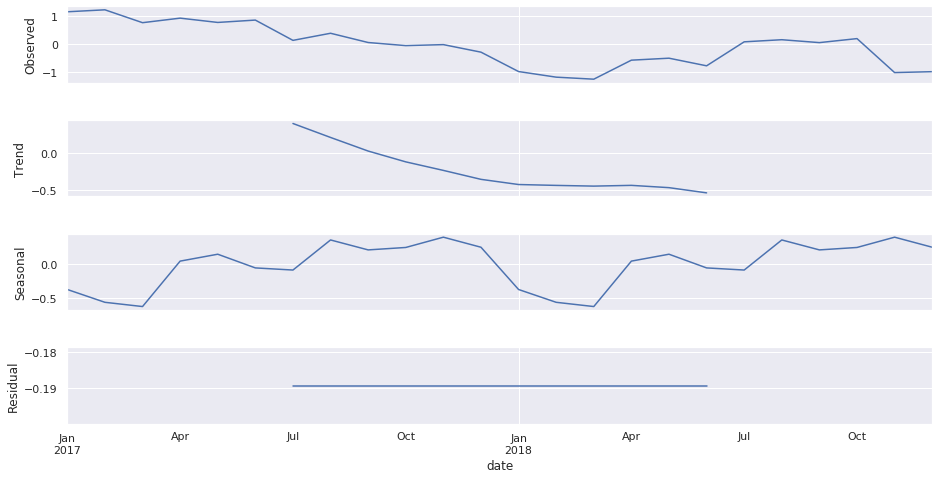

2019-01-01    1.152740
2019-02-01    1.223043
2019-03-01    0.761342
2019-04-01    0.924385
2019-05-01    0.769993
2019-06-01    0.853967
2019-07-01    0.127019
Freq: MS, dtype: float64
*********************** row 40 For product Tortoise and variable Leavers - Tortoise **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  1 0 0 [0, 0, 0, 0]


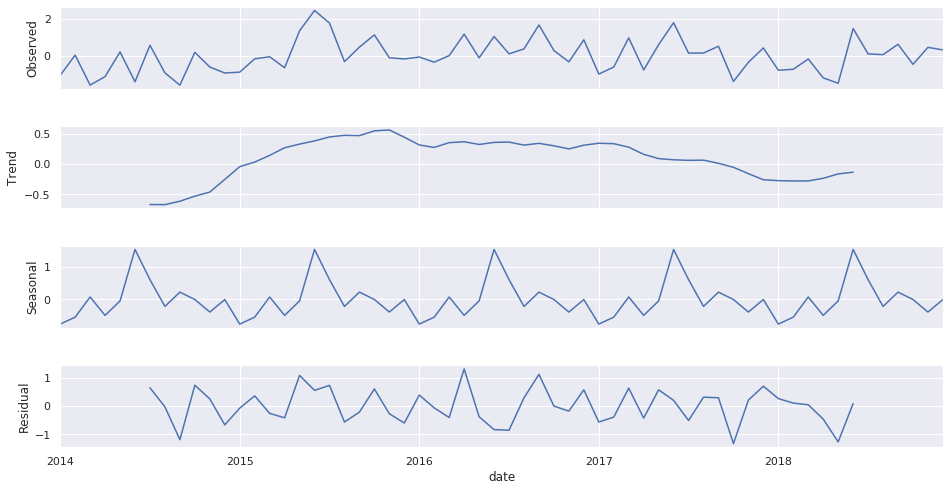

2019-01-01   -0.597791
2019-02-01   -0.420620
2019-03-01    0.199303
2019-04-01   -0.302373
2019-05-01    0.207737
2019-06-01    1.672585
2019-07-01    0.569230
Freq: MS, dtype: float64
*********************** row 41 For product Tortoise and variable Closing Base - Tortoise **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  2 1 0 [1, 0, 0, 0]


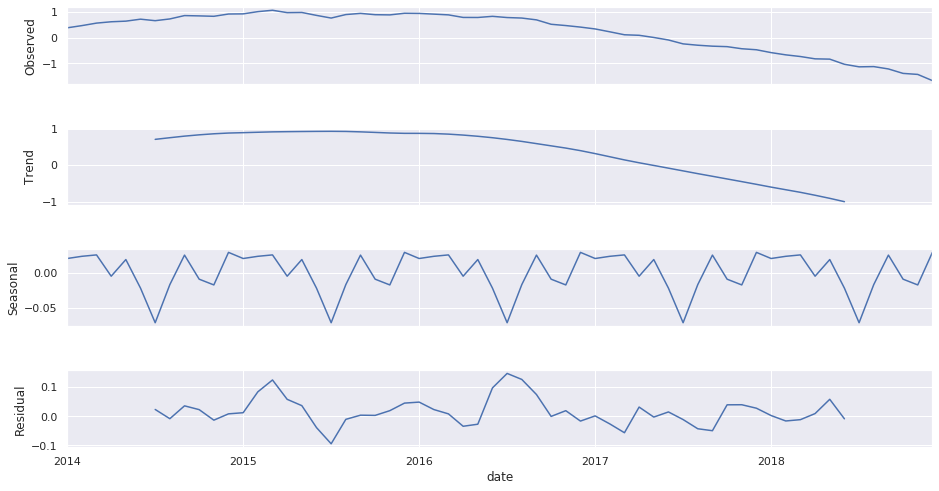

2019-01-01   -1.750680
2019-02-01   -1.852667
2019-03-01   -2.028866
2019-04-01   -2.160188
2019-05-01   -2.261590
2019-06-01   -2.389100
2019-07-01   -2.567214
Freq: MS, dtype: float64
*********************** row 42 For product Tortoise and variable Gross Adds - Tortoise **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  0 0 0 [0, 1, 1, 1]


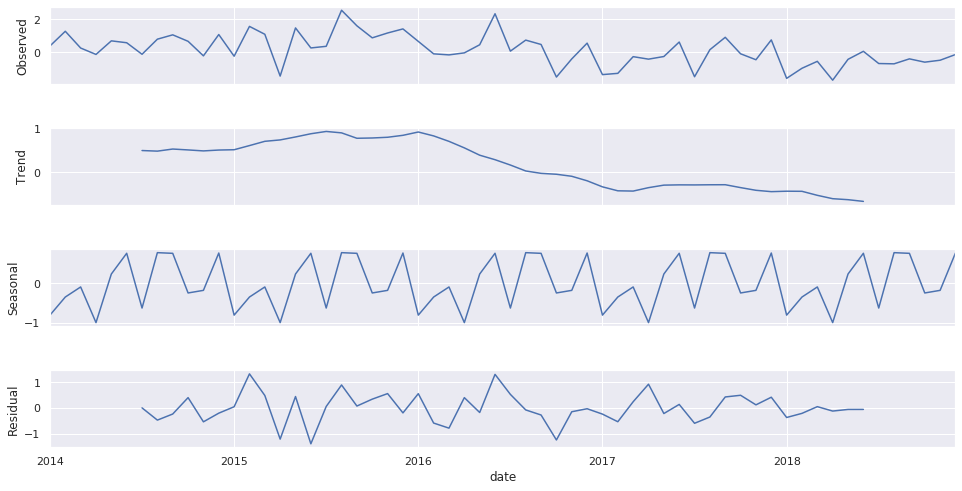

2019-01-01   -1.202753
2019-02-01   -0.642575
2019-03-01   -0.631462
2019-04-01   -1.414967
2019-05-01   -0.223496
2019-06-01    0.220174
2019-07-01   -0.866960
Freq: MS, dtype: float64
*********************** row 44 For product Tortoise and variable Net Migrations - Tortoise **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  0 0 0 [1, 0, 0, 0]


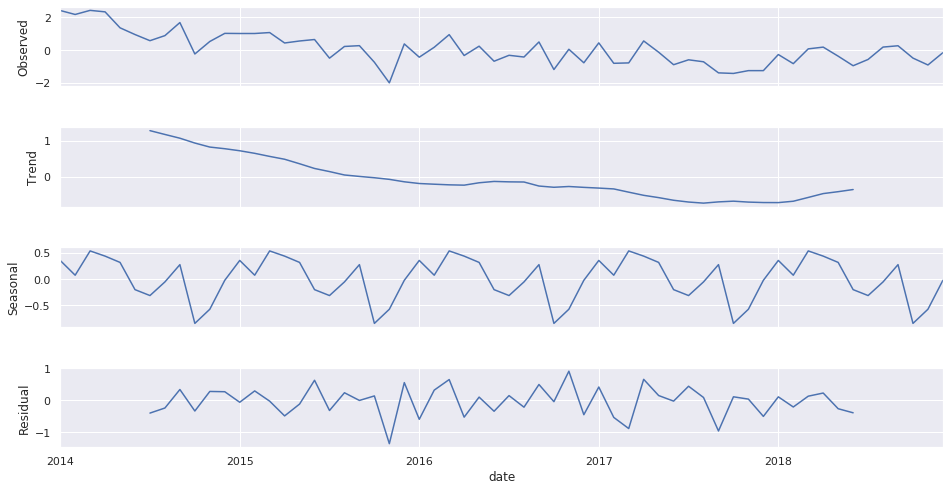

2019-01-01    0.189010
2019-02-01    0.347129
2019-03-01    0.749007
2019-04-01    0.637839
2019-05-01    0.332862
2019-06-01   -0.185260
2019-07-01   -0.278835
Freq: MS, dtype: float64
*********************** row 47 For product Tortoise and variable Revenue - Tortoise **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  0 1 0 [1, 0, 0, 0]


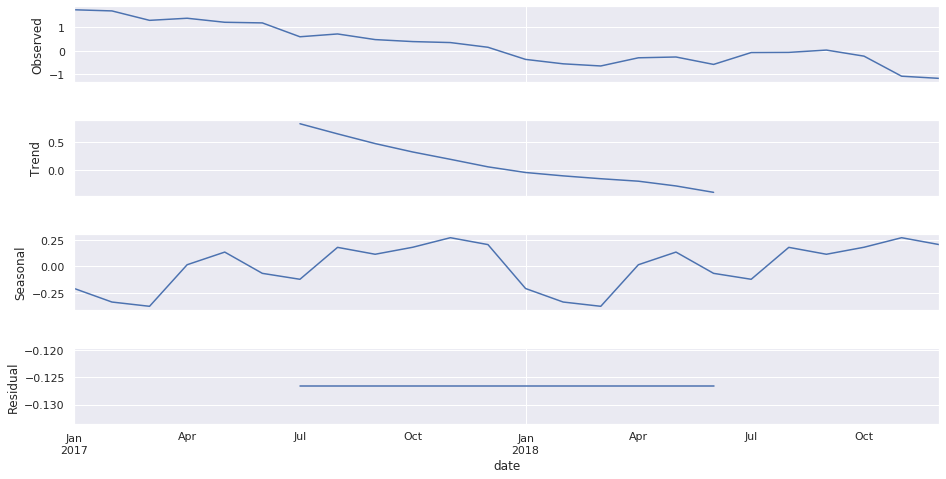

2019-01-01   -1.588179
2019-02-01   -1.682693
2019-03-01   -1.681508
2019-04-01   -1.244914
2019-05-01   -1.119423
2019-06-01   -1.340104
2019-07-01   -0.748162
Freq: MS, dtype: float64
*********************** row 48 For product Falcon and variable Average Revenue per existing customer Excl Line Rental - Falcon **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  1 0 0 [1, 1, 1, 1]


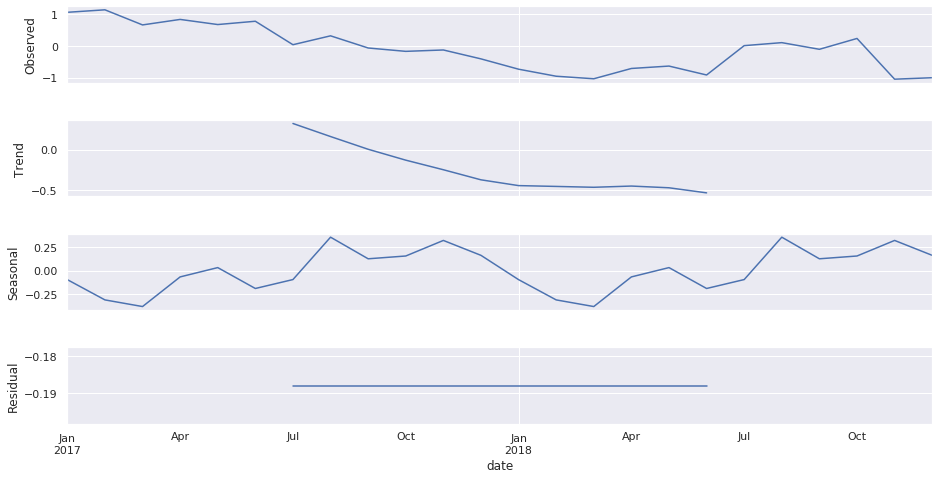

2019-01-01    1.096892
2019-02-01    1.141490
2019-03-01    0.596654
2019-04-01    0.679916
2019-05-01    0.404551
2019-06-01    0.372014
2019-07-01   -0.532636
Freq: MS, dtype: float64
*********************** row 49 For product Falcon and variable Churn - Falcon **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  1 0 1 [0, 0, 1, 0]


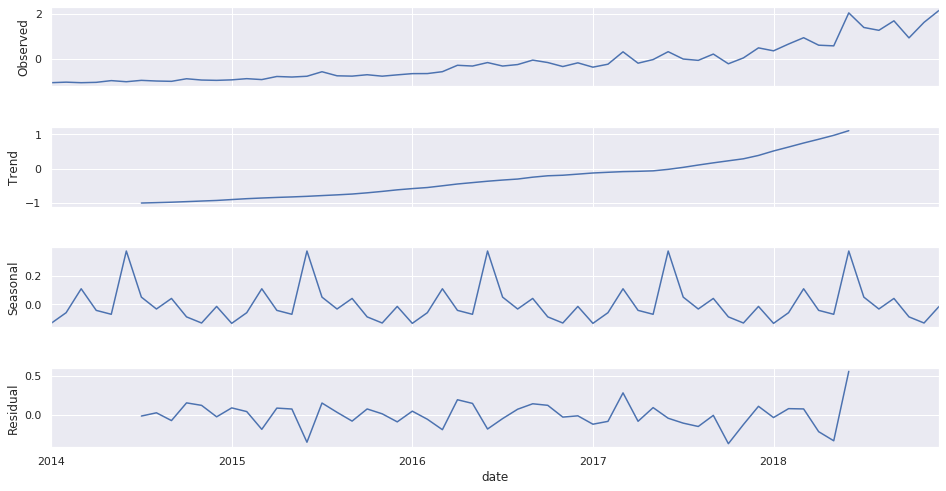

2019-01-01    3.565744
2019-02-01    4.095315
2019-03-01    4.851810
2019-04-01    4.373876
2019-05-01    4.437950
2019-06-01    6.376340
2019-07-01    5.497014
Freq: MS, dtype: float64
*********************** row 50 For product Falcon and variable Closing Base - Falcon **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  3 1 0 [1, 1, 0, 0]


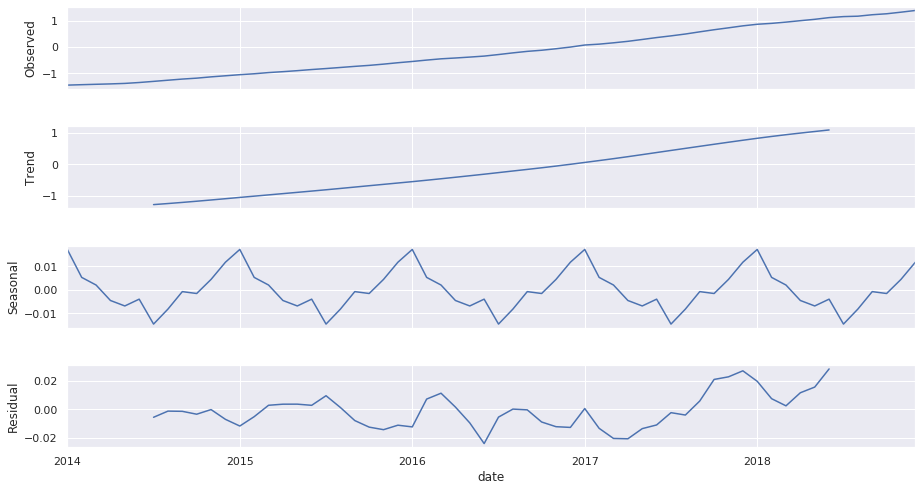

2019-01-01    1.431755
2019-02-01    1.499492
2019-03-01    1.548217
2019-04-01    1.571863
2019-05-01    1.589859
2019-06-01    1.613295
2019-07-01    1.668259
Freq: MS, dtype: float64
*********************** row 51 For product Falcon and variable Gross Adds - Falcon **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  0 0 1 [1, 0, 1, 1]


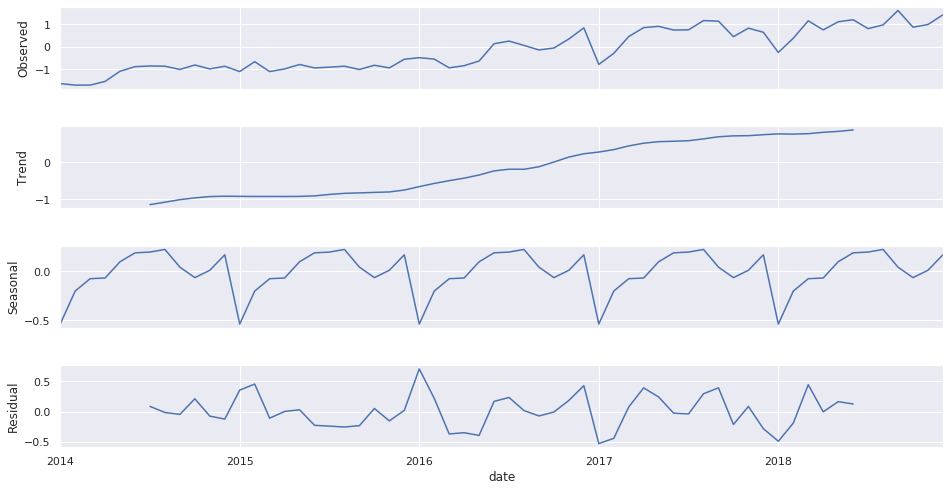

2019-01-01    0.173020
2019-02-01    0.344213
2019-03-01    0.249599
2019-04-01    0.414492
2019-05-01    0.631445
2019-06-01    0.778887
2019-07-01    0.793713
Freq: MS, dtype: float64
*********************** row 53 For product Falcon and variable Net Migrations - Falcon **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  0 0 0 [1, 0, 0, 0]


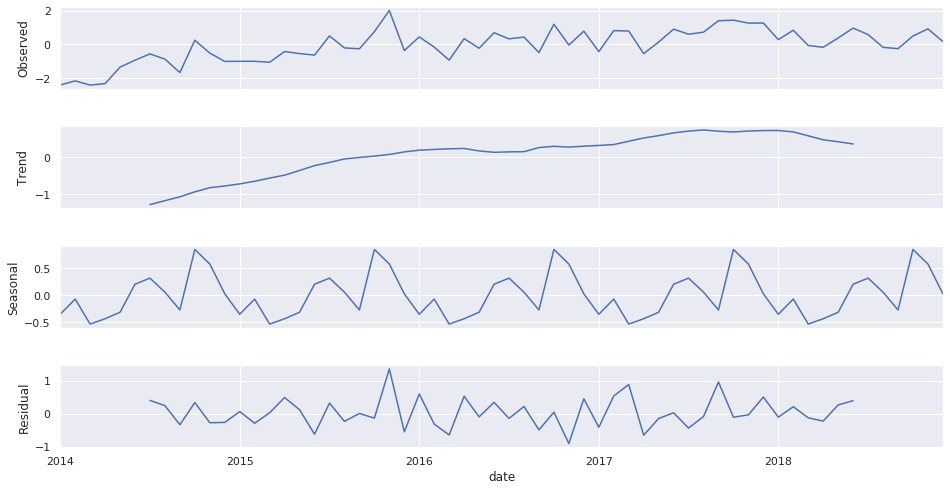

2019-01-01   -0.189020
2019-02-01   -0.347139
2019-03-01   -0.749017
2019-04-01   -0.637849
2019-05-01   -0.332872
2019-06-01    0.185250
2019-07-01    0.278825
Freq: MS, dtype: float64
*********************** row 55 For product Falcon and variable Revenue - Falcon **************************
choosing parameters for sarimax model
Final parameters p,d,q and trend of sarimax are  0 0 0 [1, 1, 1, 0]


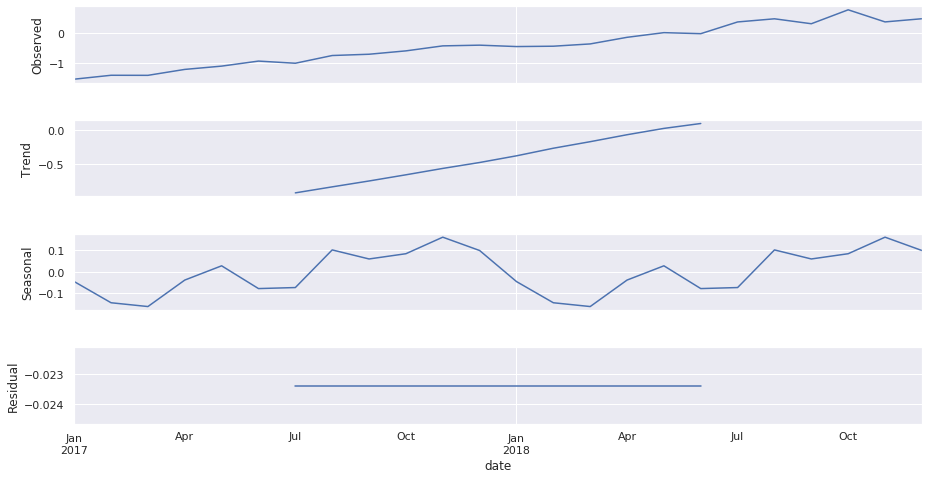

2019-01-01    0.573146
2019-02-01    0.663477
2019-03-01    0.693179
2019-04-01    0.877893
2019-05-01    1.003962
2019-06-01    1.062386
2019-07-01    1.192724
Freq: MS, dtype: float64


In [11]:
for dx in indexes:
    i=0
    train=[]
    test=[]
    test_dx=[]
    tr_start,tr_end = '!','!'
    te_start,te_end = '!','!'
    last=0
    while i<worksheet.ncols:
        ab=str(type(worksheet.cell(dx,i).value))=="<class 'float'>"
        if ab==True and len(str(worksheet.cell(dx,i).value))>0:#create train data
            date=str(worksheet.cell(0,i).value)
            date=convert_to_date(date)
            val=worksheet.cell(dx,i).value
            rw=[]
            rw.append(date)
            rw.append(val)
            train.append(rw)
            if tr_start=='!':
                tr_start=date
            tr_end=date
            last=i
        elif str(worksheet.cell(dx,i).value)=='x':#create test data
            date=str(worksheet.cell(0,i).value)
            date=convert_to_date(date)
            rw=[]
            rw.append(date)
            test.append(rw)
            address=[]
            address.append(dx)
            address.append(i)
            test_dx.append(address)
            if te_start=='!':
                te_start=date
            te_end=date
        i+=1
    #fix saved anomalies with new value
    for i in range(0,len(train)):
        if str(train[i][0]) in fix_anomalies[dx]:
            train[i][1]=fix_anomalies[dx][str(train[i][0])]
    dad=6
    print("*********************** row "+str(dx)+" For product "+str(worksheet.cell(dx,3).value)+" and variable "+str(worksheet.cell(dx,5).value)+" **************************")
    p,d,q,trendd=best_parameters(dx,last-dad,0,fix_anomalies[dx],1)#find parameters of sarimax model
    train=pd.DataFrame(train)
    train.columns=['date','value']
    train['date']=pd.to_datetime(train['date'])
    train=train.set_index('date')
    test=pd.DataFrame(test)
    test.columns=['date']
    test['date']=pd.to_datetime(test['date'])
    test=test.set_index('date')
    df=pd.concat([train,test],sort=True)
    buf=df.copy()
    ##### make feature!
    buf['quarter']=buf.index.quarter
    quarter_dummies=pd.get_dummies(buf['quarter'])
    quarter_dummies.columns = ['quarter-' + str(m) for m in range(min(buf.index.quarter),max(buf.index.quarter)+1)]
    buf = pd.concat([buf,quarter_dummies],axis=1,join_axes=[buf.index]).drop(['quarter'],axis=1)
    ##### make feature!
    buf['month']=buf.index.month
    month_dummies=pd.get_dummies(buf['month'])
    month_dummies.columns = ['month-' + str(m) for m in range(min(buf.index.month),max(buf.index.month)+1)]
    buf = pd.concat([buf,month_dummies],axis=1,join_axes=[buf.index]).drop(['month'],axis=1)
    #### these figures help you very much in understanding shape of series
    res=sm.tsa.seasonal_decompose(buf.value.dropna(),freq=12)
    fig=res.plot()
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()
    tra = buf['value'][tr_start:tr_end].dropna()
    tes = buf['value'][te_start:te_end].dropna()
    exog_train=buf.drop(['value'],axis=1)[tr_start:tr_end].dropna()
    exog_test=buf.drop(['value'],axis=1)[te_start:te_end].dropna()
    #sarimax MODEL
    sarimax = sm.tsa.statespace.SARIMAX(tra,order=(p,d,q),seasonal_order=(p,d,q,12),exog=exog_train,enforce_stationarity=False,enforce_invertibility=False,trend=trendd).fit()
    pred = sarimax.predict(tr_end,te_end,exog=exog_test)[1:]
    num=0
    for pr in pred:#replace predicted values in sheet
        ii=test_dx[num][0]
        jj=test_dx[num][1]
        worksheet._cell_values[ii][jj]=pr
        num+=1
    #for rw in anomalies_indexs:#replace fixed anomalies values in sheet
    #    for cl in anomalies_indexs[rw]:
    #        worksheet._cell_values[rw][cl]=anomalies_indexs[rw][cl]
    print(pred)

<h4>Now should save result of predictions.</h4>

In [12]:
wb=xlsxwriter.Workbook('output/submission.xlsx')
ws = wb.add_worksheet('sheet')
for i in range(0,worksheet.nrows):
    for j in range(0,worksheet.ncols):
        ws.write(i,j,worksheet.cell(i,j).value)
wb.close()